In [2]:
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from itertools import product
from typing import List
import pandas as pd
import numpy as np
import numba as nb
import imageio
import sys
import os
import shutil

randomSeed = 10

if "ipykernel_launcher.py" in sys.argv[0]:
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.jet(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

import seaborn as sns

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
if os.path.exists("/opt/conda/bin/ffmpeg"):
    plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"
else:
    plt.rcParams['animation.ffmpeg_path'] = "D:/Programs/ffmpeg/bin/ffmpeg.exe"

colors = ["#5C49AC", "#1F9BCE", "#00B5CA", "#BED45F", "#F9E03B"]
cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)
cmap_r = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors[::-1])

from main import *

In [37]:
J = 0.1
agnetsCount = 500
Fs = np.linspace(0, 5, 30)
Ks = np.linspace(-1, 1, 30)
TNum = 500

targetPath = f"./data/lastStateJ{J}.h5"  # lastStateAfter  # lastStateRing  # lastState

totalPositionX = pd.read_hdf(targetPath, key="positionXs")
totalPhaseTheta = pd.read_hdf(targetPath, key="phaseThetas")

modelNums = totalPositionX.shape[0] // agnetsCount

totalPositionX = totalPositionX.values.reshape(modelNums, agnetsCount, 2)
totalPhaseTheta = totalPhaseTheta.values.reshape(modelNums, agnetsCount)

idx = 0
positionXs = dict()
phaseThetas = dict()

models = [
    MobileDrive(agentsNum=500, K=K, J=0.1, F=F, dt=0.02) 
    for F in Fs
    for K in Ks
]
for model in tqdm(models):
    
    model.positionX = totalPositionX[idx]
    model.phaseTheta = totalPhaseTheta[idx]
    model.counts = TNum * model.shotsnaps
    model.update_temp()
    for i in range(30):
        model.update()
    # model.counts = TNum * model.shotsnaps

    idx += 1

  0%|          | 0/900 [00:00<?, ?it/s]

In [58]:
# save last state
models = [
    MobileDrive(agentsNum=500, K=K, J=0.1, F=F,
                 tqdm=False, savePath="./data", randomSeed=10, overWrite=False) 
    for F in Fs
    for K in Ks
]

savePath = "./data/L2lastStateJ0.1.h5"
if os.path.exists(savePath):
    os.remove(savePath)

store = pd.HDFStore(savePath)

for model in tqdm(models):
    store.append(key="positionXs", value=pd.DataFrame(model.positionX))
    store.append(key="phaseThetas", value=pd.DataFrame(model.phaseTheta))

store.close()

  0%|          | 0/900 [00:00<?, ?it/s]

In [38]:
model = models[-1]

In [39]:
K, H, G, P = model.K, model.H, model.G, model.P
dim = P.shape[0]
pointTheta = K * np.sum(H * G, axis=1) / dim + P
# plt.scatter(range(model.agentsNum), pointTheta)
pointTheta

array([ 1.54297023,  1.64356961,  1.54795895,  1.6787638 ,  1.63444517,
        1.70686903,  1.71347148,  1.65489284,  1.50216162,  1.64063935,
        1.54602858,  1.6288743 ,  1.57444054,  1.56487972,  1.60353752,
       41.85054955,  1.52601098,  1.6525285 ,  1.71470258,  1.69739175,
        1.65852559,  1.70412886,  1.64847314,  1.69348905,  1.5799771 ,
        1.56999219,  1.50658981,  1.71279477,  1.56715744,  1.50165937,
        1.68961597,  1.59979159,  1.68915236,  1.66354308,  1.66059863,
        1.68000526,  1.6296331 ,  1.57895407,  1.6483693 ,  1.50838133,
        1.56200996,  1.52469076,  1.61357092,  1.59090588,  1.5866063 ,
        1.5477208 ,  1.74160007,  1.59821692,  1.54961231,  1.61128957,
        1.6689421 ,  1.69963473,  1.65664751,  1.56599815,  1.6167127 ,
        1.62186324,  1.51795766,  1.67562072,  1.64146284,  1.52204353,
        1.68130813,  1.70177428,  1.60521305,  1.63001631,  1.54244439,
        1.63854474,  1.61439053,  1.65575427,  1.58005512,  1.73

In [52]:
class StateAnalysis:
    def __init__(self, model: MobileDrive, lookIndex: int = -1, showTqdm: bool = False):
        self.model = model
        self.lookIndex = lookIndex
        self.showTqdm = showTqdm
        
        targetPath = f"{self.model.savePath}/{self.model}.h5"
        totalPositionX = pd.read_hdf(targetPath, key="positionX")
        totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
        
        TNum = totalPositionX.shape[0] // self.model.agentsNum
        self.TNum = TNum
        self.tRange = np.arange(0, TNum * model.shotsnaps, model.shotsnaps) * self.model.dt
        self.totalPositionX = totalPositionX.values.reshape(TNum, self.model.agentsNum, 2)
        self.totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, self.model.agentsNum)
        self.totalDrivePosition = np.array([
            model.druveRadiusR * np.cos(model.driveAngularVelocityW * self.tRange),
            model.druveRadiusR * np.sin(model.driveAngularVelocityW * self.tRange)
        ]).transpose(1, 0)
        self.totalDrivePhaseTheta = np.mod(model.drivePhaseVelocityOmega * self.tRange, 2 * np.pi)

        self.centersValue = None
        self.classesValue = None

        if self.showTqdm:
            self.iterObject = tqdm(range(1, self.totalPhaseTheta.shape[0]))
        else:
            self.iterObject = range(1, self.totalPhaseTheta.shape[0])
            
    @staticmethod
    def calc_order_parameter_R(model: MobileDrive) -> float:
        return np.abs(np.sum(np.exp(1j * model.phaseTheta))) / model.agentsNum
    
    @staticmethod
    def calc_order_parameter_S(model: MobileDrive) -> float:
        phi = np.arctan2(model.positionX[:, 1], model.positionX[:, 0])
        Sadd = np.abs(np.sum(np.exp(1j * (phi + model.phaseTheta)))) / model.agentsNum
        Ssub = np.abs(np.sum(np.exp(1j * (phi - model.phaseTheta)))) / model.agentsNum
        return np.max([Sadd, Ssub])
    
    @staticmethod
    @nb.njit
    def _calc_pointX(Iatt, Irep, Fatt, Frep):
        dim = Iatt.shape[0]
        return np.sum(
            Iatt * Fatt.reshape((dim, dim, 1)) - Irep * Frep.reshape((dim, dim, 1)),
            axis=1
        ) / dim

    @staticmethod
    def calc_order_parameter_Vp(model: MobileDrive) -> float:
        Iatt, Irep, Fatt, Frep = model.Iatt, model.Irep, model.Fatt, model.Frep
        pointX = StateAnalysis._calc_pointX(Iatt, Irep, Fatt, Frep)
        phi = np.arctan2(pointX[:, 1], pointX[:, 0])
        return np.abs(np.sum(np.exp(1j * phi))) / model.agentsNum
    
    @staticmethod
    def calc_order_parameter_Ptr(model: MobileDrive) -> float:
        K, H, G, P = model.K, model.H, model.G, model.P
        dim = P.shape[0]
        pointTheta = K * np.sum(H * G, axis=1) / dim + P
        Ntr = np.abs(pointTheta - model.driveThateVelocityOmega) < 0.15 / model.dt * 0.1
        return Ntr.sum() / model.agentsNum

In [43]:
StateAnalysis.calc_order_parameter_Ptr(model)

0.998

In [44]:
maps1 = pd.DataFrame(index=Fs, columns=Ks, dtype=np.float64)
for model in models:
    maps1.loc[model.F, model.K] = StateAnalysis.calc_order_parameter_R(model)

maps2 = pd.DataFrame(index=Fs, columns=Ks, dtype=np.float64)
for model in tqdm(models):
    maps2.loc[model.F, model.K] = StateAnalysis.calc_order_parameter_Ptr(model)

maps3 = pd.DataFrame(index=Fs, columns=Ks, dtype=np.float64)
for model in models:
    maps3.loc[model.F, model.K] = StateAnalysis.calc_order_parameter_S(model)

maps4 = pd.DataFrame(index=Fs, columns=Ks, dtype=np.float64)
for model in tqdm(models):
    maps4.loc[model.F, model.K] = StateAnalysis.calc_order_parameter_Vp(model)

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

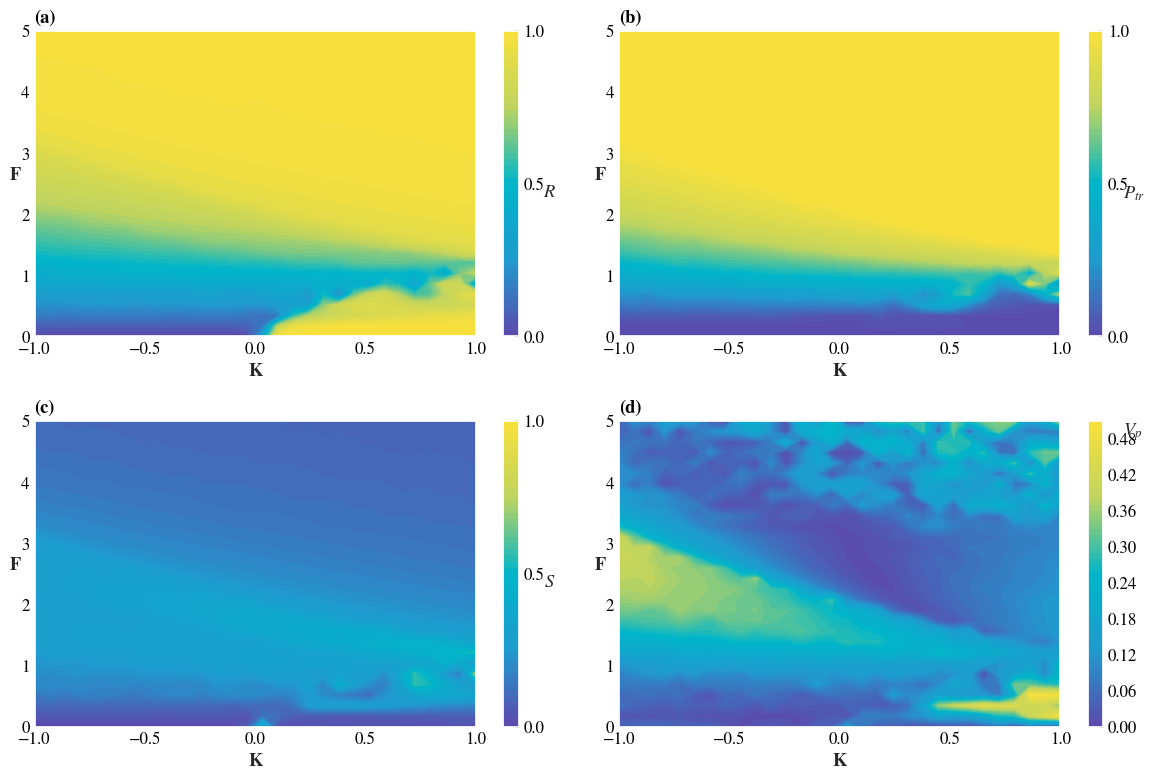

In [49]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
ax1, ax2, ax3, ax4 = axs.flatten()

levels = 50

cf1 = ax1.contourf(
    maps1.columns.values, maps1.index.values, 
    maps1.values, levels=levels, vmin=0, vmax=1,
    cmap=cmap, alpha=1
)
ax1.set_xlabel(r"K", fontweight="bold")
ax1.set_xticks([-1, -0.5, 0, 0.5, 1])
ax1.set_ylabel(r"F", fontweight="bold", rotation=0)
ax1.grid(False)
ax1.set_title("(a)", fontweight="bold", loc="left")
cbar1 = plt.colorbar(cf1, ax=ax1, ticks=[0, 0.5, 1])
cbar1.ax.tick_params(direction='in', length=3)
cbar1.set_label(r"$R$", fontweight="bold", rotation=0)

cf2 = ax2.contourf(
    maps2.columns.values, maps2.index.values, 
    maps2.values, levels=levels, vmin=0, vmax=1,
    cmap=cmap, alpha=1
)
ax2.set_xlabel(r"K", fontweight="bold")
ax2.set_xticks([-1, -0.5, 0, 0.5, 1])
ax2.set_ylabel(r"F", fontweight="bold", rotation=0)
ax2.grid(False)
ax2.set_title("(b)", fontweight="bold", loc="left")
cbar2 = plt.colorbar(cf2, ax=ax2, ticks=[0, 0.5, 1])
cbar2.ax.tick_params(direction='in', length=3)
cbar2.set_label(r"$P_{tr}$", fontweight="bold", rotation=0)

stdMaps3 = maps3 / maps3.max().max()
cf3 = ax3.contourf(
    maps3.columns.values, maps3.index.values, 
    stdMaps3.values, levels=levels, vmin=0, vmax=1,
    cmap=cmap, alpha=1
)
ax3.contourf(
    maps3.columns.values, maps3.index.values, 
    maps3.values, levels=levels, vmin=0, vmax=1,
    cmap=cmap, alpha=1
)
ax3.set_xlabel(r"K", fontweight="bold")
ax3.set_xticks([-1, -0.5, 0, 0.5, 1])
ax3.set_ylabel(r"F", fontweight="bold", rotation=0)
ax3.grid(False)
ax3.set_title("(c)", fontweight="bold", loc="left")
cbar3 = plt.colorbar(cf3, ax=ax3, ticks=[0, 0.5, 1])
cbar3.ax.set_ylim(0, 1)
cbar3.ax.tick_params(direction='in', length=3)
cbar3.set_label(r"$S$", fontweight="bold", rotation=0)

cf4 = ax4.contourf(
    maps4.columns.values, maps4.index.values, 
    maps4.values, levels=levels, # vmin=0, vmax=1,
    cmap=cmap, alpha=1
)
ax4.set_xlabel(r"K", fontweight="bold")
ax4.set_xticks([-1, -0.5, 0, 0.5, 1])
ax4.set_ylabel(r"F", fontweight="bold", rotation=0)
ax4.grid(False)
ax4.set_title("(d)", fontweight="bold", loc="left")
cbar4 = plt.colorbar(cf4, ax=ax4)
cbar4.ax.tick_params(direction='in', length=3)
cbar4.set_label(r"$V_p$", fontweight="bold", rotation=0, loc="top")

for ax in axs.flatten():
    ax.tick_params(direction='in', length=3)

plt.tight_layout()

In [50]:
cbar4.set_label?

Signature: cbar4.set_label(label, *, loc=None, **kwargs)
Docstring:
Add a label to the long axis of the colorbar.

Parameters
----------
label : str
    The label text.
loc : str, optional
    The location of the label.

    - For horizontal orientation one of {'left', 'center', 'right'}
    - For vertical orientation one of {'bottom', 'center', 'top'}

    Defaults to :rc:`xaxis.labellocation` or :rc:`yaxis.labellocation`
    depending on the orientation.
**kwargs
    Keyword arguments are passed to `~.Axes.set_xlabel` /
    `~.Axes.set_ylabel`.
    Supported keywords are *labelpad* and `.Text` properties.
File:      d:\anaconda3\envs\py37\lib\site-packages\matplotlib\colorbar.py
Type:      method


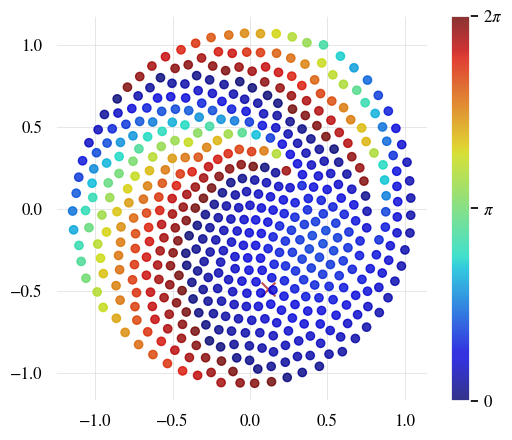

In [46]:
model = models[220]
model.plot()